# Segmentation methodology for Chameleon

In [9]:
from inference_pipeline import heuristic
# This code has been tested on Python 3.11.7
! pip install -r requirements.txt

error: externally-managed-environment

× This environment is externally managed
╰─> To install Python packages system-wide, try apt install
    python3-xyz, where xyz is the package you are trying to
    install.
    
    If you wish to install a non-Debian-packaged Python package,
    create a virtual environment using python3 -m venv path/to/venv.
    Then use path/to/venv/bin/python and path/to/venv/bin/pip. Make
    sure you have python3-full installed.
    
    If you wish to install a non-Debian packaged Python application,
    it may be easiest to use pipx install xyz, which will manage a
    virtual environment for you. Make sure you have pipx installed.
    
    See /usr/share/doc/python3.12/README.venv for more information.

note: If you believe this is a mistake, please contact your Python installation or OS distribution provider. You can override this, at the risk of breaking your Python installation or OS, by passing --break-system-packages.
hint: See PEP 668 for the detai

In [10]:
import importlib
import multiprocessing
import numpy as np
from tqdm.auto import tqdm
from matplotlib import pyplot as plt
from tsfresh.feature_extraction.settings import (
    MinimalFCParameters,
    EfficientFCParameters,
)

from unsupervised_learning.unsupervised_sliding_windows_classification import classifyTrace_unsupervised, saveClassification
from inference_pipeline.segmentation import *
from inference_pipeline.debug import *

import inference_pipeline.heuristic as heuristic
importlib.reload(heuristic)
import unsupervised_learning.vectorization as vectorization
importlib.reload(vectorization)
import unsupervised_learning.classification as classification
importlib.reload(classification)

fc_params = EfficientFCParameters()
# Removing the least efficient features
fc_params.pop('query_similarity_count', None) # Often not applicable
fc_params.pop('augmented_dickey_fuller', None)
fc_params.pop('number_cwt_peaks', None)
fc_params.pop('agg_linear_trend', None)
fc_params.pop('change_quantiles', None) # Checked again from here
fc_params.pop('lempel_ziv_complexity', None)
fc_params.pop('permutation_entropy', None)

window_size = 10_000
stride = 50 #50

#vectorizer = vectorization.TSFreshVectorizer(fc_params=fc_params, n_jobs=min(int(multiprocessing.cpu_count()/1.2), 64))
vectorizer = vectorization.AutoencoderVectorizer(window_size=window_size, latent_dim=32,  include_latent=True)
classifier = classification.KMeansClassifier(n_clusters=9)

In [11]:
dataset = 'BASE'
chunk = 1

chameleon_file = f"datasets/{dataset}/chameleon_base_chunk_{chunk}.h5"
output_file = "temporary_files/output_file.npy"

batch_size = vectorizer.batch_data_points//window_size

Compute and save segmentation as file `output_file`.
Function _classifyTrace_ has a few parameters to configure based on the experiment:

- `stride`: Define the stride to use for the sliding window.
- `window_size`: Define the size of the sliding window itself.

In [ ]:
scores = classifyTrace_unsupervised(
    trace_file=chameleon_file,
    vectorizer=vectorizer,
    classifier=classifier,
    stride=stride,
    window_size=window_size,
    tmp_folder = "temporary_files",
    batch_size=batch_size, # Bigger batch size hit's the memory limit of th docker
    stored_features_path = None # Remove or non to extract new features, path in temporary_files otherwise
)

saveClassification(scores, output_file)
'''
Stride:
500: 4.5h
'''
'''
Shell command to watch memory usage:
max=0;
limit=$(($(cat /sys/fs/cgroup/memory.max)/1024/1024/1024));
while :; do
  cur=$(($(cat /sys/fs/cgroup/memory.current)/1024/1024/1024));
  if [ $cur -gt $max ]; then max=$cur; fi
  avail=$((limit - cur))
  echo "Current: ${cur} GiB | Max: ${max} GiB | Available: ${avail} GiB"
  sleep 60
done
'''
""


Building all_X memmap: 100%|██████████| 16/16 [13:03<00:00, 48.97s/it]


Feature dimension after pipeline: 344/653


## Screening

Compute the segmenation and find the starting sample of each cryptographic operation.

In [ ]:
classification_file = output_file#"temporary_files/classification_output_file"

labels = loaderGt(chameleon_file)
classifications = np.load(classification_file, mmap_mode='r')

gts_starts = []
gts_ends = []
for label in labels:
    gts_starts.append(label['start'])
    gts_ends.append(label['end'])

init_min_distance = 150_000

In [ ]:
major_filter_size = 150
CPs = []

for classification, gt, gt_e in tqdm(zip(classifications, gts_starts, gts_ends), total=len(classifications)):
    CPs.append(segment(classification, major_filter_size, stride, init_min_distance))

Remove false positive and false negatives from the identified COs

In [ ]:
starts = []
ends = []

for idx in tqdm(range(len(CPs))):
    s, e = heuristic.removeFalsePositives_basic(CPs[idx]['starts'], CPs[idx]['ends'])
    s, e = heuristic.removeFalseNegatives(s, e, classifications[idx])
    starts.append(s)
    ends.append(e)

In [ ]:
fnrs_s, fprs_s = [],[]
fnrs_e, fprs_e = [],[]

for idx in tqdm(range(len(CPs))):
    fpr, fnr = errorRate(gts_starts[idx], np.asarray(starts[idx]), stride)
    fprs_s.append(fpr)
    fnrs_s.append(fnr)
    fpr, fnr = errorRate(gts_ends[idx], np.asarray(ends[idx]), stride)
    fprs_e.append(fpr)
    fnrs_e.append(fnr)

'''
TSFRESH, Stride 50, PCA 80: 29, 21, 30, 20
AUTO32, Stride 50, PCA 0.95: 0, 40, 0, 40
AUTO16, Stride 50, PCA 0.95: 0, 61, 0, 61
'''
    
print(f"Total start mean FPR: {round(np.mean(fprs_s)*100,2)}%")
print(f"Total start mean FNR: {round(np.mean(fnrs_s)*100,2)}%")
print(f"Total end mean FPR: {round(np.mean(fprs_e)*100,2)}%")
print(f"Total end mean FNR: {round(np.mean(fnrs_e)*100,2)}%")

## Visualization

Visualize the detected COs and ground truth (GT) for a given trace.

**First Subplot**: Draws black vertical lines for detected COs' _starts_ and red dashed vertical lines for GT.  
**Second Subplot**: Draws grey vertical lines for detected COs' _ends_ and yellow dashed vertical lines for GT.  
**Third Subplot**: Plots classification for each point in the trace.

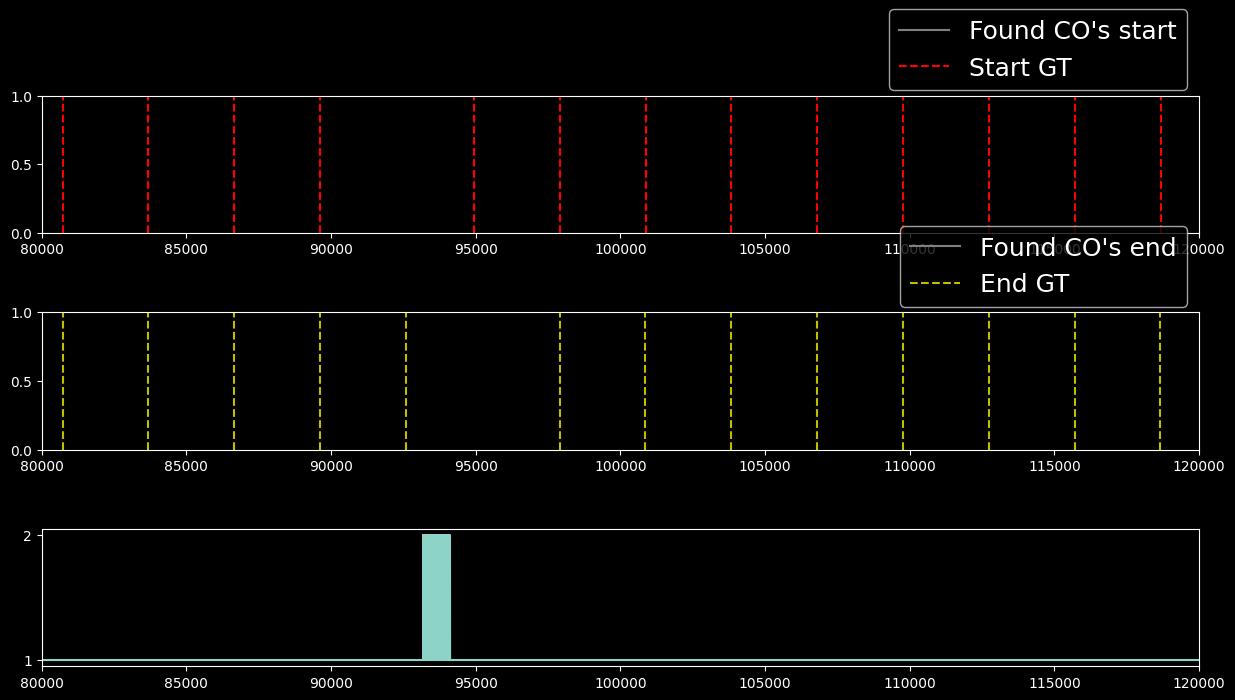

In [8]:
n_trace = 0
center = 100_000
margin = 20_000
lim = (center-margin, center+margin)

fig, ax = plt.subplots(3, figsize=(13, 7))
plt.rcParams.update({'font.size': 18})
fig.tight_layout(pad=2.0)

ax[0].set_xlim(lim)
for sample in starts[n_trace][1:]:
    ax[0].axvline(x=sample, color='grey', linestyle='-')
ax[0].axvline(x=starts[n_trace][0], color='grey', linestyle='-', label="Found CO's start")

for sample in gts_starts[n_trace][1:]:
    ax[0].axvline(x=sample//stride, color='r', linestyle='--')
ax[0].axvline(x=gts_starts[n_trace][0]//stride, color='r', linestyle='--', label='Start GT')
ax[0].legend(loc='lower right', bbox_to_anchor=(1, 0.95))


ax[1].set_xlim(lim)
for sample in ends[n_trace][1:]:
    ax[1].axvline(x=sample, color='grey', linestyle='-')
ax[1].axvline(x=ends[n_trace][0], color='grey', linestyle='-', label="Found CO's end")

for sample in gts_ends[n_trace][1:]:
    ax[1].axvline(x=sample//stride, color='y', linestyle='--')
ax[1].axvline(x=gts_ends[n_trace][0]//stride, color='y', linestyle='--', label='End GT')
ax[1].legend(loc='lower right', bbox_to_anchor=(1, 0.95))


ax[2].set_xlim(lim)
ax[2].plot(np.argmax(classifications[n_trace], axis=1))